# 国债期货策略研究

In [6]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import datetime
import statsmodels.api as sm
import scipy
from tqdm import tqdm_notebook 
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from statsmodels import api as stm 
from statsmodels import tools
from scipy.optimize import minimize
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import prettytable as pt
from numpy import random
import gc 
import psutil
import os
plt.style.use("seaborn")
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
%config InlineBackend.figure_format='retina'
%matplotlib inline

## 数据清洗

In [12]:
year = [15,16,17,18,19,20,21]*4
year = sorted(year)
month = ['03','06','09','12']*7
file_name = ['T'+str(x)+y + '.CCFX.xlsx' for x,y in zip(year,month)]
#print('内存使用占比：',psutil.Process(os.getpid()).memory_info().rss/info.total)
def draw_data(raw_data):
    data = raw_data[['close','volume']]
    data=data[data.index.minute.isin(list(range(0,60,10)))] #这里假设用的是10min来进行slice
    data['close'] = data['close'].pct_change()
    return data

def get_return_flow(future1,future2):
    #输入两个期货价格的dataframe，需注意future1是已有的序列，future2是要加入的序列
    nn = pd.concat([future1,future2],axis=1)
    index = nn[(nn.iloc[:,1]<nn.iloc[:,3]).values].index[1]
    result = pd.concat([future1.loc[:index].iloc[:-1],future2.loc[index:]],axis=0)
    return result

initial =1
for name in file_name:
    print("处理文件"+name)
    #print('内存使用占比：',psutil.Process(os.getpid()).memory_info().rss/info.total)
    try:
        file_location = './data_minute/'+name
        raw_data = pd.read_excel(file_location,index_col=0 )
    except:
        continue
        
    if initial==1:
        initial =0
        future1 = draw_data(raw_data)
        del raw_data
        gc.collect()
        continue
        
    future2 = draw_data(raw_data)
    try:
        future1 = get_return_flow(future1,future2)
    except:
        print("数据整合结束")
        break
    del future2, raw_data
    gc.collect()
future1.iloc[0,0] = 0
future_return = future1[future1.iloc[:,1]>0]#只取成交量大于零的部分
future_return.columns = ['收益','成交量']
future_price = future_return.copy()
future_price.iloc[:,0] = (future_price.iloc[:,0]+1).cumprod()
future_price.columns = ['价格','成交量']

处理文件T1503.CCFX.xlsx
处理文件T1506.CCFX.xlsx
处理文件T1509.CCFX.xlsx
处理文件T1512.CCFX.xlsx
处理文件T1603.CCFX.xlsx
处理文件T1606.CCFX.xlsx
处理文件T1609.CCFX.xlsx
处理文件T1612.CCFX.xlsx
处理文件T1703.CCFX.xlsx
处理文件T1706.CCFX.xlsx
处理文件T1709.CCFX.xlsx
处理文件T1712.CCFX.xlsx
处理文件T1803.CCFX.xlsx
处理文件T1806.CCFX.xlsx
处理文件T1809.CCFX.xlsx
处理文件T1812.CCFX.xlsx
处理文件T1903.CCFX.xlsx
处理文件T1906.CCFX.xlsx
处理文件T1909.CCFX.xlsx
处理文件T1912.CCFX.xlsx
处理文件T2003.CCFX.xlsx
处理文件T2006.CCFX.xlsx
处理文件T2009.CCFX.xlsx
处理文件T2012.CCFX.xlsx
处理文件T2103.CCFX.xlsx
处理文件T2106.CCFX.xlsx
处理文件T2109.CCFX.xlsx
数据整合结束


## 信号产生

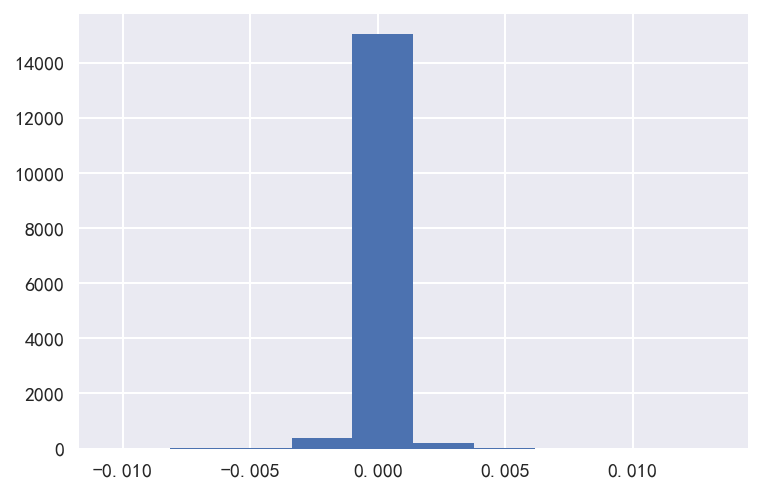

In [290]:
all_data.iloc[:,0].diff().hist()

In [308]:
price_ave = pd.DataFrame(future_price.iloc[:,0].rolling(int(500)).mean())
price_ave.columns =["300分钟价格均线"]
volume_ave = pd.DataFrame(future_price.iloc[:,1].rolling(int(500)).mean())
volume_ave.columns = ["300分钟成交量均线"]
all_data = pd.concat([future_price, price_ave,volume_ave ],axis=1).dropna()
signal_data = pd.DataFrame(np.zeros(len(all_data)),index = all_data.index)
position_data = pd.DataFrame(np.zeros(len(all_data)),index = all_data.index)

signal_data[(((all_data.iloc[:,0]-all_data.iloc[:,2])>0.005).values*(all_data.iloc[:,1]/all_data.iloc[:,3])>3).values] = 1
signal_data[(((all_data.iloc[:,0]-all_data.iloc[:,2])<-0.05).values*(all_data.iloc[:,1]/all_data.iloc[:,3])>5).values]= -1

i =0
length = 20
while i < len(all_data):
    if (signal_data.iloc[i]>0).values[0]:        
        position_data.iloc[i+1:i+1+length] = 1
        i=i+length
    if (signal_data.iloc[i]<0).values[0]:
        position_data.iloc[i+1:i+1+length] = -1
        i=i+length
    i=i+1

input_price = pd.DataFrame(all_data["价格"])
input_position = position_data.copy()

In [309]:
(signal_data>0).sum()
(signal_data<0).sum()

0    0
dtype: int64

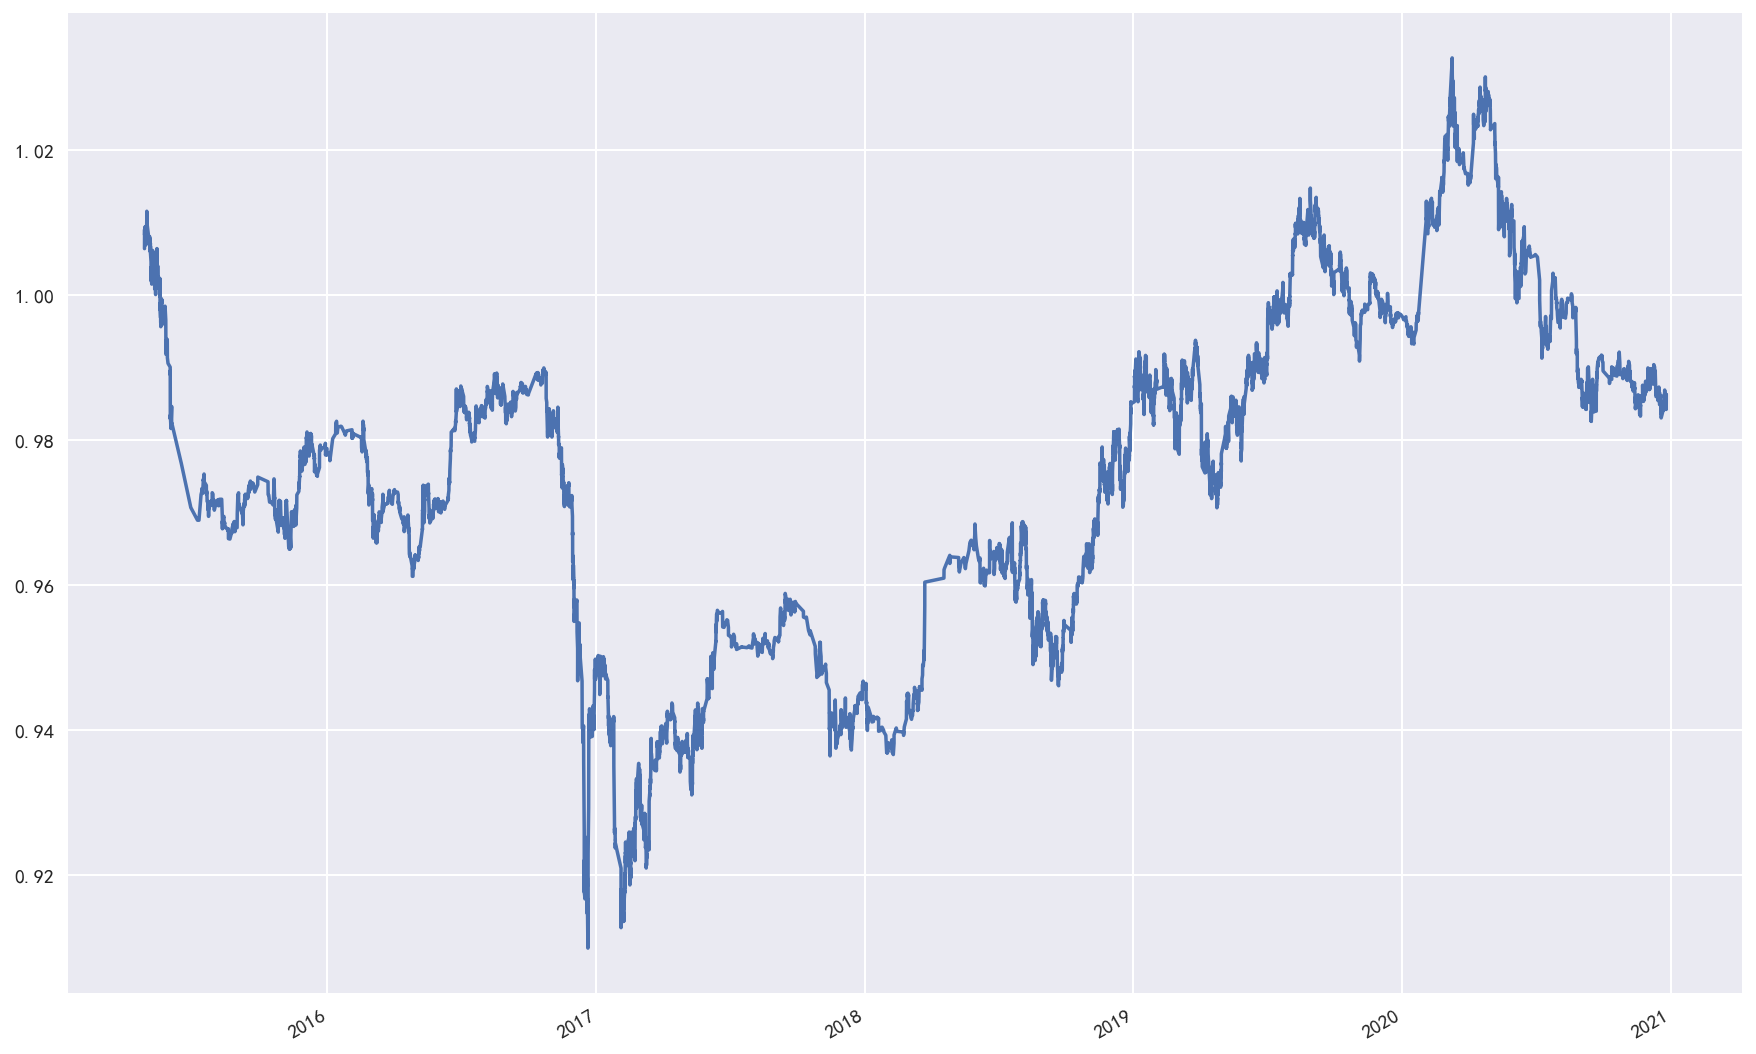

In [310]:
all_data.iloc[:,0].plot(figsize=(15,10))

In [312]:
position=pd.DataFrame(np.ones(len(input_price)),index = input_price.index)

In [319]:
new.net_value.idxmax()

0   2020-03-09 11:00:00
dtype: datetime64[ns]

In [ ]:
new

+--------------+---------------------+
|              |     回测结果展示    |
+--------------+---------------------+
|  年化收益率  |        -0.002       |
|  年化波动率  |        0.023        |
|    夏普比    |        -0.086       |
|     胜率     |         0.0         |
|     赔率     |         nan         |
|   做多胜率   |         0.0         |
|   做多赔率   |         nan         |
|   做空胜率   |         nan         |
|   做空赔率   |         nan         |
|   最大回撤   |        -0.101       |
| 回测开始时间 | 2015-04-27 11:30:00 |
| 回测结束时间 | 2020-12-25 15:10:00 |
+--------------+---------------------+


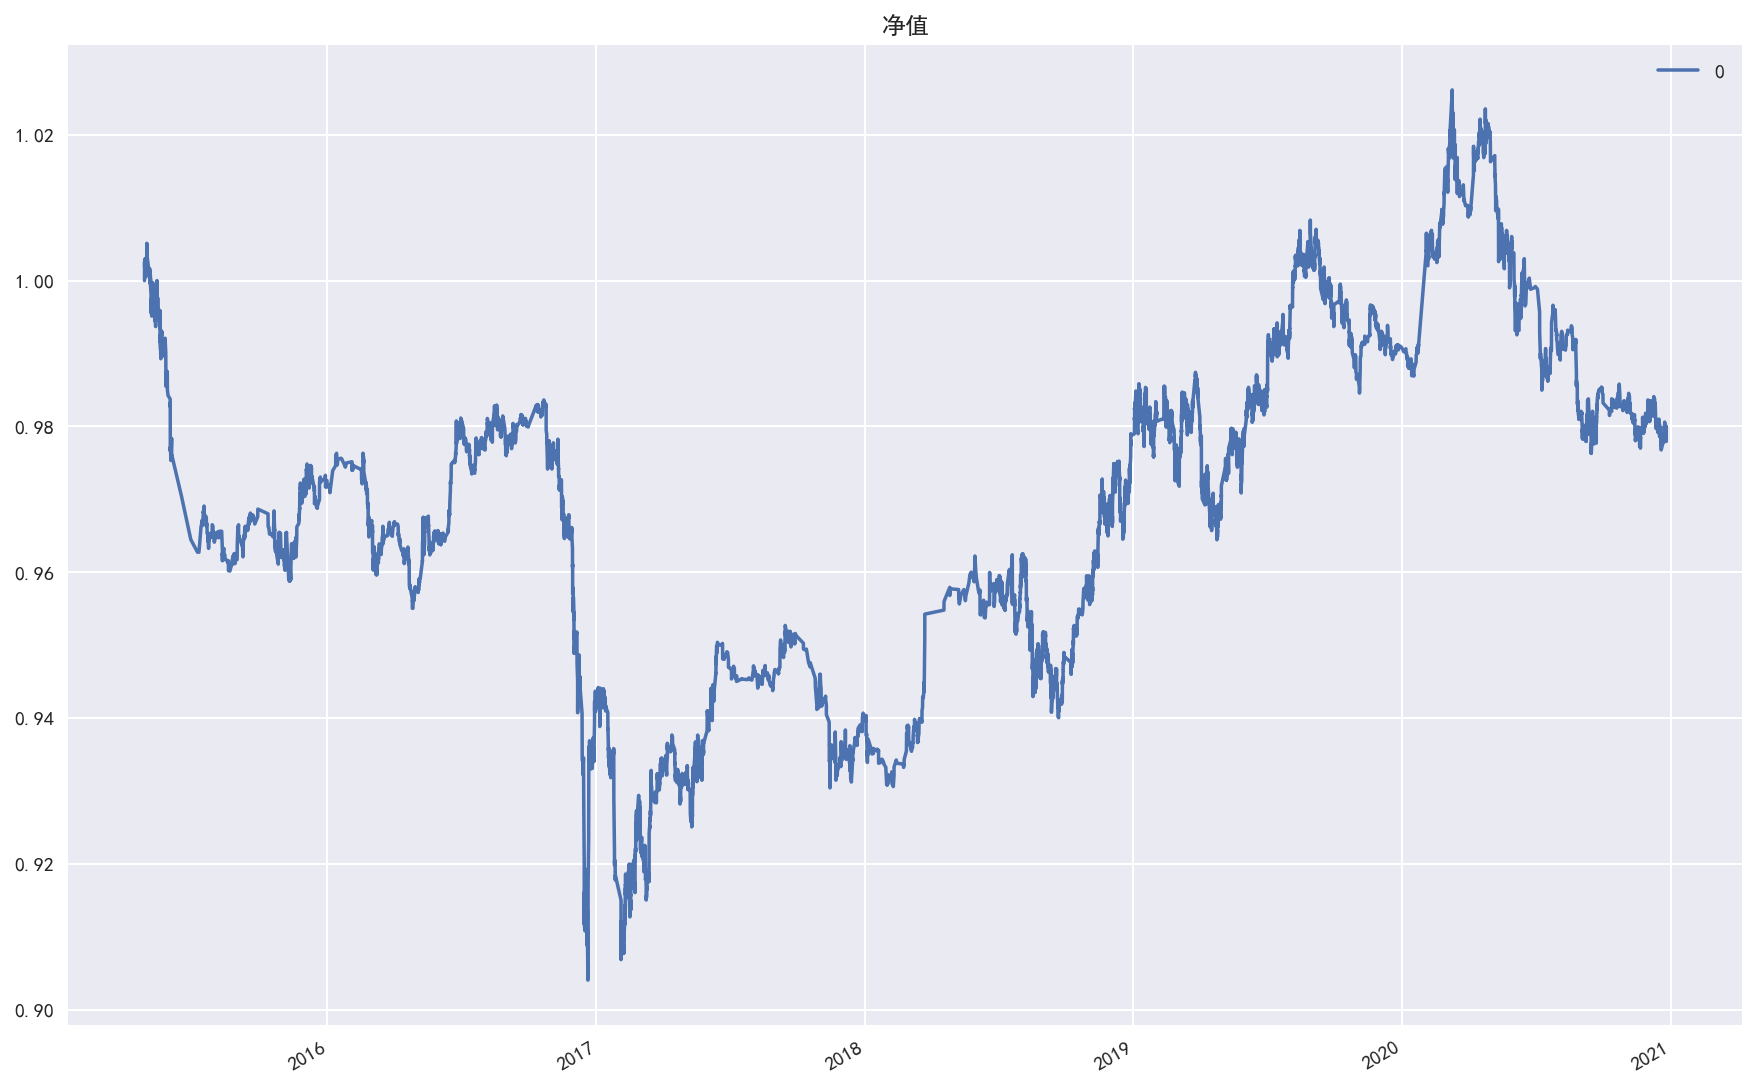

In [313]:
new = back_test(position, input_price)
new.show_result()
new.result_plot()

## 回测结果

In [242]:
class back_test():
    # 输入的信号应该是时间点，当天仓位的大小
    # 价格应该是所有时间点的价格数据
    #输入数据格式都是dataframe格式
    def __init__(self,position, price):
        
        self.position = pd.DataFrame(position.values,index = position.index) 
        self.asset_return = price.pct_change()
        self.asset_return.iloc[0] = 0
        
    def calculate_net_value(self):
        self.each_return = pd.DataFrame(self.position.values*self.asset_return.values, index = self.position.index)
        self.net_value = (self.each_return+1).cumprod()
    
    def drawdown(self):
        self.withdraw = (self.net_value-self.net_value.cummax())/self.net_value.cummax()
        self.max_withdraw = (new.withdraw).min().values[0]
        
    def win_and_odd(self):
        #用operation来记录是否清仓，如果清仓则计入一次操作，可以用来计算胜率等指标，如果是则计1
        operation = pd.DataFrame(np.zeros([len(self.position),1]),index = self.position.index)
        #long_short用来判断清仓前的这次操作是多/空操作，多的话计1，空计-1
        long_short = pd.DataFrame(np.zeros([len(self.position),1]),index = self.position.index)
        #当仓位变成0的时候需要记下清仓,同时需要判断本次是否是否相比上个时间点是否调仓了
        #虽然这里的仓位0表示的是上一个交易时点结束时或者本次交易时间点开始时清仓，但是不影响计算结果
        operation[(self.position == 0).values*(self.position.diff().abs()>0).values] = 1 
        
        #如果多翻空或者空翻多,认为中间发生了清仓，记一次操作,这里的记时指的是该交易时间点结束时清仓
        change_position = np.append((new.position.values[:-1]*new.position.values[1:]<0),[self.position.iloc[-1]>0])
        operation[change_position] = 1 
        
        #用来记录每次操作是盈利/亏损
        self.each_operation_return = pd.DataFrame(np.zeros([len(self.position),1]),index = self.position.index)
        self.each_operation_return[(operation>0).values] = self.net_value[(operation>0).values].pct_change()#每次操作的收益
        
        long_short[(operation>0).values] = (self.position[(operation>0).values] > 0 )*1+( self.position[(operation>0).values] < 0 )*(-1)#如果是多翻空的情况
        #如果是清仓的情况
        long_short[(self.position == 0).values*(self.position.diff()>0).values] = -1
        long_short[(self.position == 0).values*(self.position.diff()<0).values] = 1  
        
        self.win_rate = (self.each_operation_return>0).sum().values[0]/(operation.abs()>0).sum().values[0]
        self.odds_rate = -self.each_operation_return[(self.each_operation_return>0)].sum().values[0]/self.each_operation_return[(self.each_operation_return<0)].sum().values[0]
        
        long_operation_return = self.each_operation_return[(long_short>0).values]
        short_operation_return = self.each_operation_return[(long_short<0).values]
        self.long_win_rate = (long_operation_return>0).sum().values[0]/(long_short>0).sum().values[0] 
        self.short_win_rate = (short_operation_return>0).sum().values[0]/(long_short<0).sum().values[0]
        self.long_odds_rate = ( -long_operation_return[(long_operation_return>0)].sum()/long_operation_return[(long_operation_return<0)].sum() ).values[0]
        self.short_odds_rate = ( -short_operation_return[(short_operation_return>0)].sum()/short_operation_return[(short_operation_return<0)].sum() ).values[0]

        
    #计算年化回报、年化波动率和夏普比
    def sharpe_ratio(self,frequency):
        self.annual_return = self.net_value.values[-1,0]**(frequency/len(self.net_value))-1
        self.annual_std = self.each_return.values.std()*np.sqrt(frequency)
        self.sharpe = self.annual_return/self.annual_std
    
    def show_result(self):
        self.calculate_net_value()
        self.sharpe_ratio(250*6)
        self.drawdown()
        self.win_and_odd()
        tb = pt.PrettyTable()
        tb.field_names = ["   ","回测结果展示"]
        tb.add_row(["年化收益率",self.annual_return.round(3)])
        tb.add_row(["年化波动率",self.annual_std.round(3)])
        tb.add_row(["夏普比",self.sharpe.round(3)])
        tb.add_row(["胜率",self.win_rate.round(3)])
        tb.add_row(["赔率",self.odds_rate.round(3)])
        tb.add_row(["做多胜率",self.long_win_rate.round(3)])
        tb.add_row(["做多赔率",self.long_odds_rate.round(3)])
        tb.add_row(["做空胜率",self.short_win_rate.round(3)])
        tb.add_row(["做空赔率",self.short_odds_rate.round(3)])
        tb.add_row(["最大回撤",self.max_withdraw.round(3)])
        
        tb.add_row(["回测开始时间",str(self.position.index[0])])
        tb.add_row(["回测结束时间",str(self.position.index[-1])])
        
        print(tb)
        
    def result_plot(self):
        self.net_value.plot(legend=True,figsize=(15,10),title='净值')
    

In [355]:
price = pd.DataFrame(np.arange(100)*3+1,index=pd.date_range(start='2019-1-09',periods=100,freq='H'))
signal = pd.DataFrame((random.random(size=(100,1))-0.5123).round(1), index = price.index)

self = back_test(signal,price)

self.calculate_net_value()

self.sharpe_ratio(250*6)

In [356]:
self.show_result()

+--------------+---------------------+
|              |     回测结果展示    |
+--------------+---------------------+
|  年化收益率  |      142558.04      |
|  年化波动率  |         3.53        |
|    夏普比    |      40385.152      |
|     胜率     |         0.25        |
|     赔率     |        1.036        |
|   做多胜率   |         0.23        |
|   做多赔率   |        36.036       |
|   做空胜率   |         0.02        |
|   做空赔率   |        0.017        |
|   最大回撤   |          0          |
| 回测开始时间 | 2019-01-09 00:00:00 |
| 回测结束时间 | 2019-01-13 03:00:00 |
+--------------+---------------------+


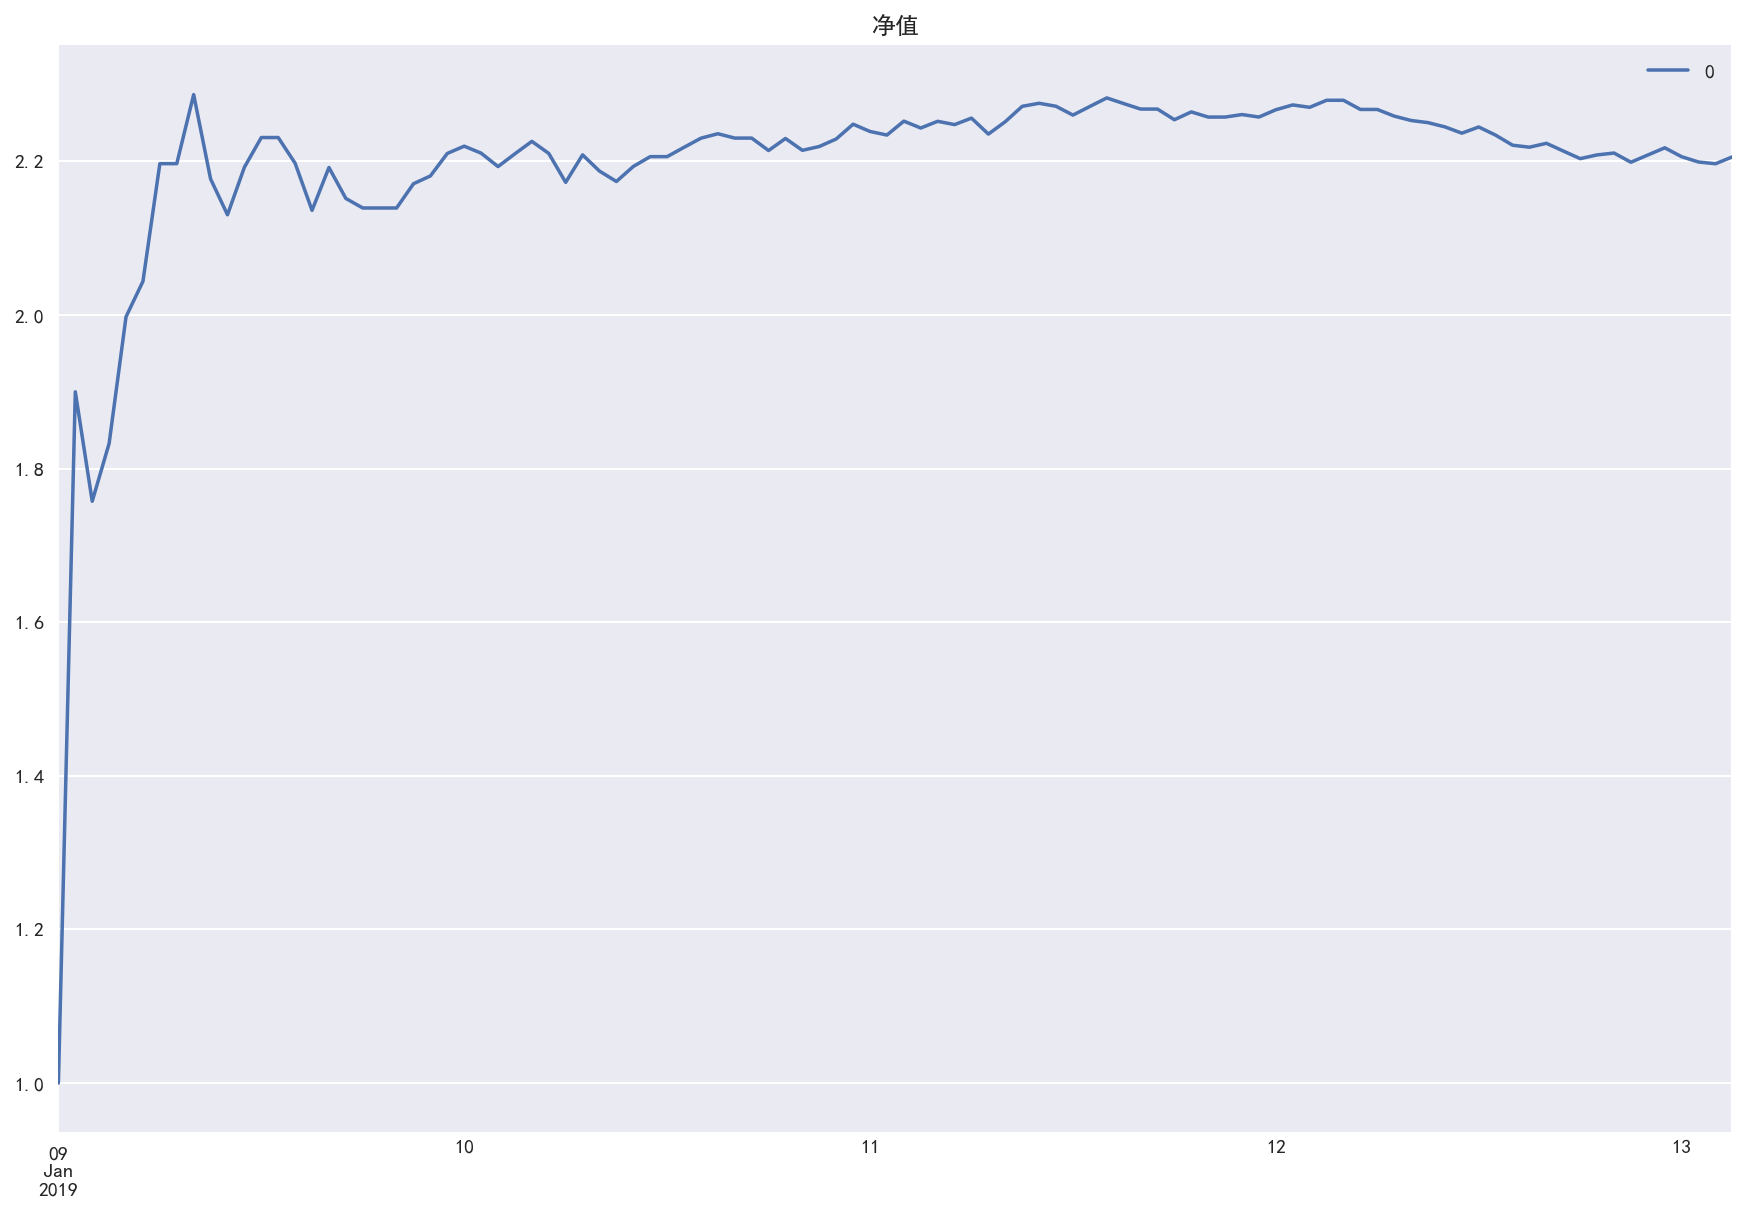

In [357]:
self.result_plot()